
### **Value at Risk (VaR)**
**Value at Risk (VaR)** is a statistical metric to measure the potential maximum loss of an investment or a portfolio at a given time period under certain a confidence level. For example, when a stock portfolio has a VaR of USD 1 million during a day at 95 \% confidence level, it means that there is 95 \% probability that this stock portfolio will NOT lose over USD 1 million in a day.


In [2]:
import pandas as pd
import numpy as np
from fredapi import Fred
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
sns.set()

## Cosidering a case where our Portfolio consists of only 3 Bonds

In [3]:
# Download Treasury yield data from FRED
fred = Fred(api_key='')  # API Key Redacted
# List of Treasury yield series IDs
series_ids = ['DGS2', 'DGS5', 'DGS10']

# Function to get data for a single series
def get_yield_data(series_id):
    data = fred.get_series(series_id, observation_start="1975-01-01", observation_end="2024-05-03")
    return data

# Get data for all series
yields_dict = {series_id: get_yield_data(series_id) for series_id in series_ids}

# Combine into a single DataFrame
yields = pd.DataFrame(yields_dict)

# Rename columns for clarity
yields.columns = ['2 Year', '5 Year', '10 Year']

In [21]:
# Create a dataset with 3 Treasury bond yields and calculate the yield changes
var_dataset = yields[["2 Year","5 Year","10 Year"]]
var_yield_chng_dataset = var_dataset.pct_change()
var_yield_chng_dataset = var_yield_chng_dataset.dropna()
var_yield_chng_dataset.head()

/var/folders/qk/0049fg855_5dzk88ykpjq8_r0000gn/T/ipykernel_92448/1466291397.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  var_yield_chng_dataset = var_dataset.pct_change()


,2 Year,5 Year,10 Year
1976-06-02,-0.004132,0.003891,0.000000
1976-06-03,-0.001383,0.001292,-0.002519
1976-06-04,-0.013850,-0.010323,-0.003788
1976-06-07,-0.004213,-0.003911,-0.001267
1976-06-08,0.002821,0.003927,0.002538


In [22]:
# Standardize the dataset
var_yield_chng_dataset_means = var_yield_chng_dataset.mean()
var_yield_chng_dataset_stds = var_yield_chng_dataset.std()
var_yld_chng_stnd_data = (var_yield_chng_dataset - var_yield_chng_dataset_means) / var_yield_chng_dataset_stds

In [23]:
# Calculate eienvectors and eigenvalues and rank by eigenvalues
var_cov_matrix = var_yld_chng_stnd_data.cov()
eigenvalues, eigenvectors = np.linalg.eig(var_cov_matrix)
sorted_indices = np.argsort(eigenvalues)[::-1]
pca_components = eigenvectors[:, sorted_indices]

In [24]:
# Put data into a DataFrame
df_eigval = pd.DataFrame({"Eigenvalues":eigenvalues}, index=range(1,4))

# Work out explained proportion
df_eigval["Explained proportion"] = df_eigval["Eigenvalues"] / np.sum(df_eigval["Eigenvalues"])
#Format as percentage
df_eigval.style.format({"Explained proportion": "{:.2%}"})

,Eigenvalues,Explained proportion
1,2.558683,85.29%
2,0.371576,12.39%
3,0.069742,2.32%


we can see the first two eigenvectors account for 97% of the variance in the dataset. Hence, we are going to select the first two eigenvectors for analysis.

In [25]:
# Choose number of components (e.g., 2)
n_components = 2
selected_components = pca_components[:, :n_components]

In [26]:
# Assumed portfolio
portfolio = {
    2: 2000000,  # $2M in 2-year bond
    5: 2000000,  # $2M in 5-year bond
    10: 1000000  # $1M in 10-year bond
}

In [27]:
# Calculate portfolio sensitivities (assuming duration = maturity for simplicity)
sensitivities = np.array([maturity * amount for maturity, amount in portfolio.items()])

# Calculate portfolio value changes
portfolio_changes = (var_yield_chng_dataset*sensitivities) @ selected_components

# Calculate VaR
confidence_level = 0.95  # 95% VaR
var = -np.percentile(portfolio_changes, 100 * (1 - confidence_level))

print(f"1-day 95% VaR: ${var:,.2f}")

# Display summary statistics
print("\nSummary Statistics:")
print(f"Portfolio Value: ${sum(portfolio.values()):,.2f}")
print(f"VaR as % of Portfolio Value: {var / sum(portfolio.values()) * 100:.3f}%")

1-day 95% VaR: $291,342.61

Summary Statistics:
Portfolio Value: $5,000,000.00
VaR as % of Portfolio Value: 5.827%


## The above result shows that the 1-day VaR at 95% confidence level for our simple Treasury bond portfolio is $291,342. It is about 6% of the total portfolio value.

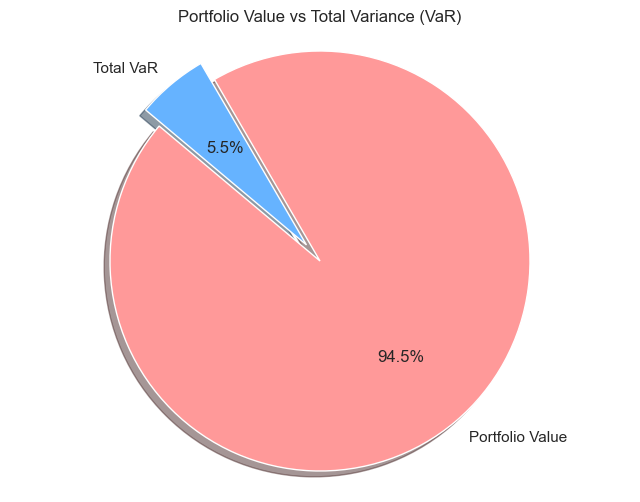

In [28]:
# Extract portfolio values and total variance
portfolio_values = list(portfolio.values())
total_portfolio_value = sum(portfolio_values)
var_value = var  # Total variance

# Prepare data for the pie chart
labels = ['Portfolio Value', 'Total VaR']
sizes = [total_portfolio_value, var_value]
colors = ['#ff9999','#66b3ff']  # Colors for the pie chart
explode = (0.1, 0)  # explode the first slice (Portfolio Value)

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
    autopct='%1.1f%%', shadow=True, startangle=140)

# Equal aspect ratio ensures that pie chart is a circle
plt.axis('equal')  
plt.title('Portfolio Value vs Total Variance (VaR)')
plt.show()

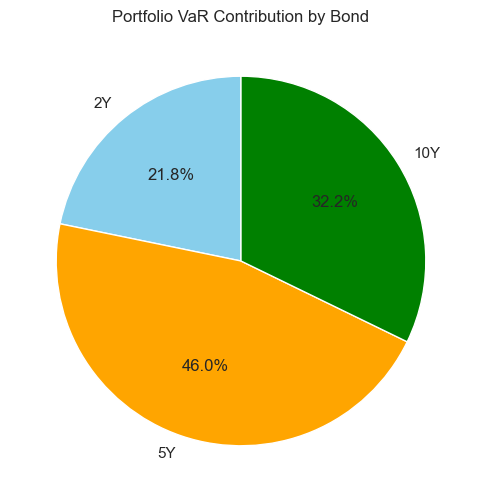

In [29]:
# Contribution of each bond to portfolio variance
# Var_i ≈ s_i * (Cov_matrix row i · sensitivities)
bond_variances = sensitivities * (cov_matrix @ sensitivities)
bond_contributions = bond_variances / bond_variances.sum()  # proportion

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(bond_contributions, labels=[f'{m}Y' for m in portfolio.keys()],
        autopct='%1.1f%%', startangle=90, colors=['skyblue','orange','green'])
plt.title('Portfolio VaR Contribution by Bond')
plt.show()
